# Optimización cudrática de carteras

El problema de la frontera eficiente se puede tratar como un problema de optimización cuadrática.

La frontera eficiente se puede encontrar solucionando el siguiente problema:

\begin{equation*}
\begin{aligned}
& \underset{}{\text{maximize}}
& &  \mathbf{w^T \mu} - \gamma \mathbf{w}^T\Sigma \mathbf{w}\\
& \text{subject to}
& & w_i \ge 0, \; i = 1,\dots, n \\
&&& \sum_{i=1}^{n} w_i = 1
\end{aligned}
\end{equation*}
Donde $\mathbf{w}$ es el vector de pesos a optimizar, $\mathbf{w^T \mu}$ es el retorno del portfolio, $\mathbf{w}^T\Sigma \mathbf{w}$ es la varianza del portfolio y $\gamma$ es un parámetro de adversión al riesgo.

Variando $\gamma$ obtenemos los diferentes puntos de la frontera. Si $\gamma=0$ maximizamos solo el retono y si  $\gamma \rightarrow \infty$ obtenemos el portfolio de mínimo riesgo. Variando  $\gamma$  obtenemos el *risk-return trade-off* óptimo.

Puedes encontrar más información en: https://en.wikipedia.org/wiki/Modern_portfolio_theory

## Cargamos los datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data/stock_data.csv', index_col=0
                   , parse_dates=True)

## Generamos carteras aleatorias

In [4]:
returns = np.log(data).diff().dropna()

cov_returns = returns.cov()
mean_returns = returns.mean()
    
list_r_p = []
list_std_p = []
list_w = []
for _ in range(100000):
    w = np.random.rand(6)
    w = w / np.sum(w)
    r_p = mean_returns.dot(w)
    std_p = np.sqrt(w @ cov_returns.values @ w)  
    list_r_p.append(r_p)
    list_std_p.append(std_p)
    list_w.append(w)

In [5]:
arr_std_p = np.array(list_std_p)
arr_r_p = np.array(list_r_p)
s_r = arr_r_p/arr_std_p
idx_m_sr = np.argmax(s_r)

In [6]:
r_m_sr = arr_r_p[idx_m_sr]
std_m_sr = arr_std_p[idx_m_sr]
w_m_sr = list_w[idx_m_sr]

In [7]:
pd.Series(w_m_sr, index=cov_returns.columns)

AAPL     0.187213
BRK-B    0.705040
GOOG     0.082778
JPM      0.009342
MMM      0.001021
VZ       0.014606
dtype: float64

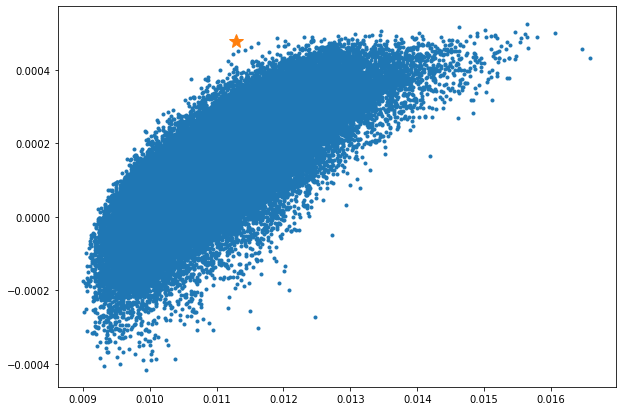

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(list_std_p, list_r_p, '.')
ax.plot(std_m_sr, r_m_sr, '*', markersize=15)
#ax.set_xlim(left=0)
#ax.set_ylim(0)

### Importamos la librería de optimización cuadrática

In [ ]:
!pip install cvxpy

In [ ]:
import cvxpy as cp

In [ ]:
def optimal_portfolio(returns, n_samples=10000, gamma_low=-1, gamma_high=10):
    sigma = returns.cov().values
    mu = np.mean(returns, axis=0).values  
    n = sigma.shape[0]        
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T*w
    risk = cp.quad_form(w, sigma)
    
    prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
                      [cp.sum(w) == 1,  w >= 0]) 
    # Equivalente 
    #prob = cp.Problem(cp.Minimize(risk - gamma*ret), 
    #                  [cp.sum(w) == 1,  w >= 0])   
    risk_data = np.zeros(n_samples)
    ret_data = np.zeros(n_samples)
    gamma_vals = np.logspace(gamma_low, gamma_high, num=n_samples)
    
    portfolio_weights = []    
    for i in range(n_samples):
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[i] = np.sqrt(risk.value)
        ret_data[i] = ret.value
        portfolio_weights.append(w.value)   
    return ret_data, risk_data, gamma_vals, portfolio_weights

In [ ]:
ret_data, risk_data, gamma_vals, portfolio_weights = optimal_portfolio(returns)

c:\Users\adriy\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


In [ ]:
s_r_2 = ret_data/risk_data
idx_m_sr_2 = np.argmax(s_r_2)
r_m_sr_2 = ret_data[idx_m_sr_2]
std_m_sr_2 = risk_data[idx_m_sr_2]
w_m_sr_2 = portfolio_weights[idx_m_sr_2]

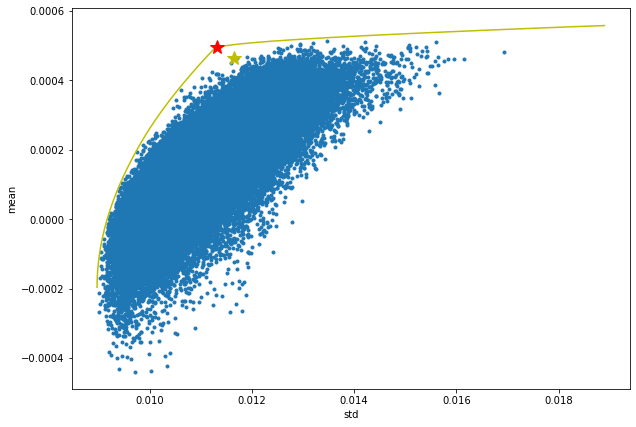

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(list_std_p, list_r_p, '.')
ax.plot(risk_data, ret_data, 'y')
ax.plot(std_m_sr, r_m_sr, '*y', markersize=15)
ax.plot(std_m_sr_2, r_m_sr_2, '*r', markersize=15)
_ = ax.set_xlabel('std')
_ = ax.set_ylabel('mean')